In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from pylab import rcParams
from keras.models import Model, load_model
#from keras.layers import Input, Dense
from tensorflow.keras.layers import Input, Dense
from tensorflow import keras
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

Using TensorFlow backend.





# Preprocessing

In [2]:
df_norm = pd.read_csv('./DataP2/cleaned.csv')

In [3]:
print(df_norm.shape)
df_norm.head()

(9622407, 98)


,Unnamed: 0,Unnamed: 0.1,date,serial_number,model,capacity_bytes,failure,smart_1_normalized,smart_1_raw,smart_2_normalized,...,smart_250_raw,smart_251_normalized,smart_251_raw,smart_252_normalized,smart_252_raw,smart_254_normalized,smart_254_raw,smart_255_normalized,smart_255_raw,days_before_failure
0,0,0,2016-01-01,MJ0351YNG9Z0XA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,135.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0
1,1,1,2016-01-01,Z305B2QN,ST4000DM000,1.976651e-311,0,113,54551400,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0
2,2,2,2016-01-01,MJ0351YNG9Z7LA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0
3,3,3,2016-01-01,MJ0351YNGABYAA,Hitachi HDS5C3030ALA630,1.482490e-311,0,100,0,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0
4,4,4,2016-01-01,WD-WMC4N2899475,WDC WD30EFRX,1.482490e-311,0,200,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000.0


In [11]:
"""le = LabelEncoder()
encoded = le.fit_transform(df['model'])
le.inverse_transform(encoded)"""

array(['Hitachi HDS5C3030ALA630', 'Hitachi HDS5C3030ALA630',
       'Hitachi HDS5C4040ALE630', ..., 'Hitachi HDS5C3030ALA630',
       'ST4000DM000', 'ST4000DM000'], dtype=object)

In [4]:
# Drop the following columns
#df_norm.drop(['date', 'model', 'serial_number', 'Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)
df_norm.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1, inplace=True)

# Drop normalized columns
df_norm = df_norm[df_norm.columns.drop(list(df_norm.filter(regex='normalized')))]

# Drop Duplicate Rows
df_norm = df_norm.drop_duplicates(subset=None, keep='first', inplace=False).reset_index(drop=True)

# Drop Columns where all entries are NAN
df_norm.dropna(axis=1, how='all', inplace=True)

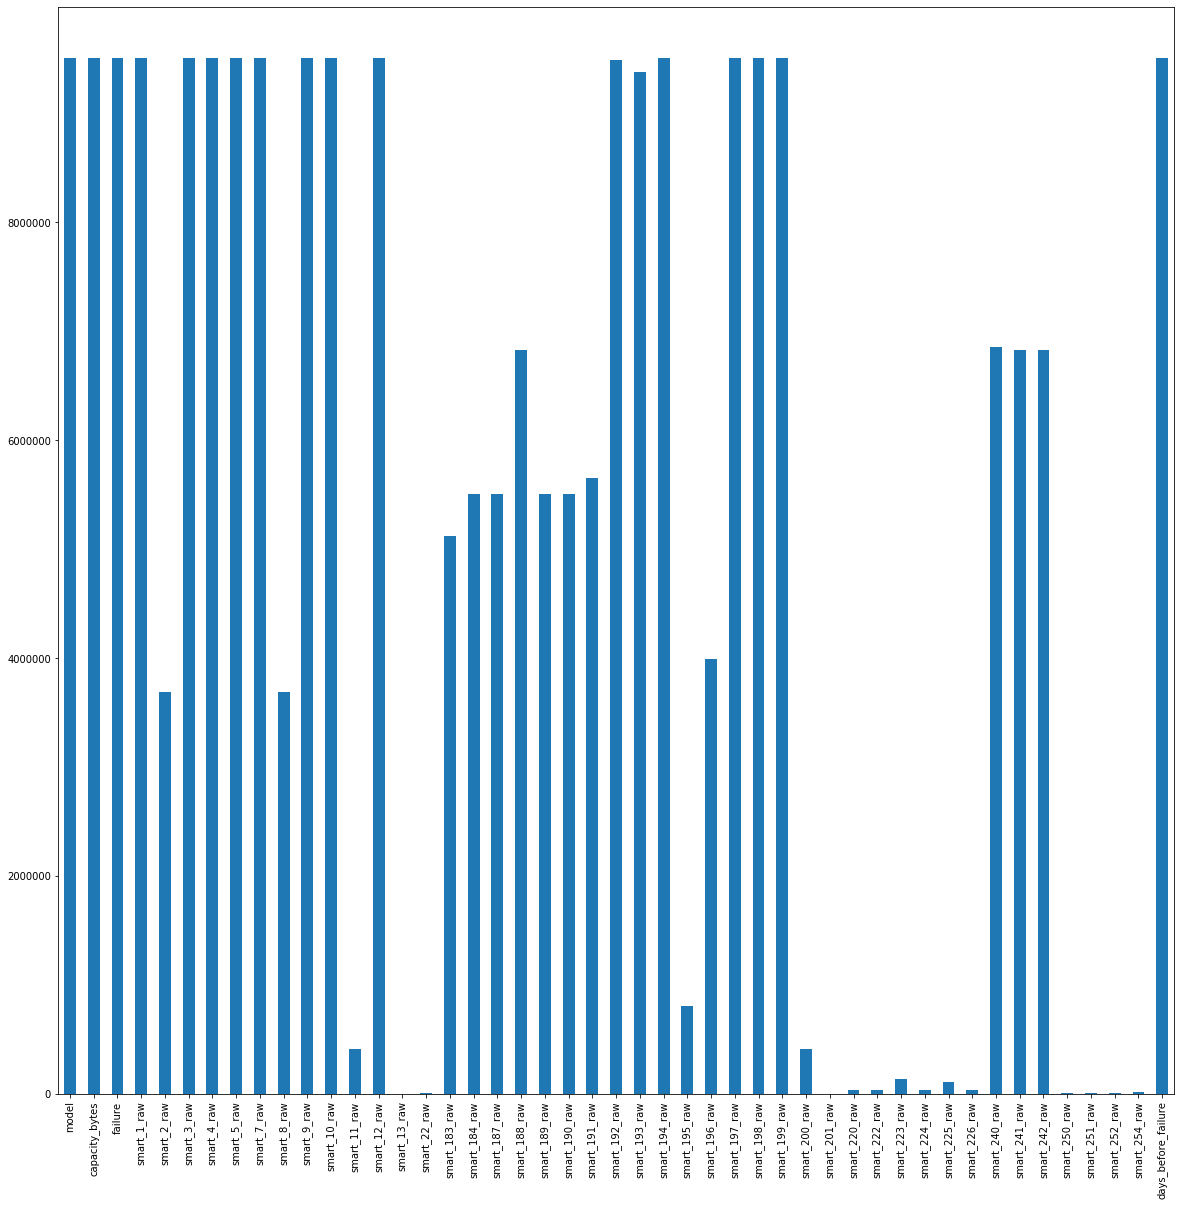

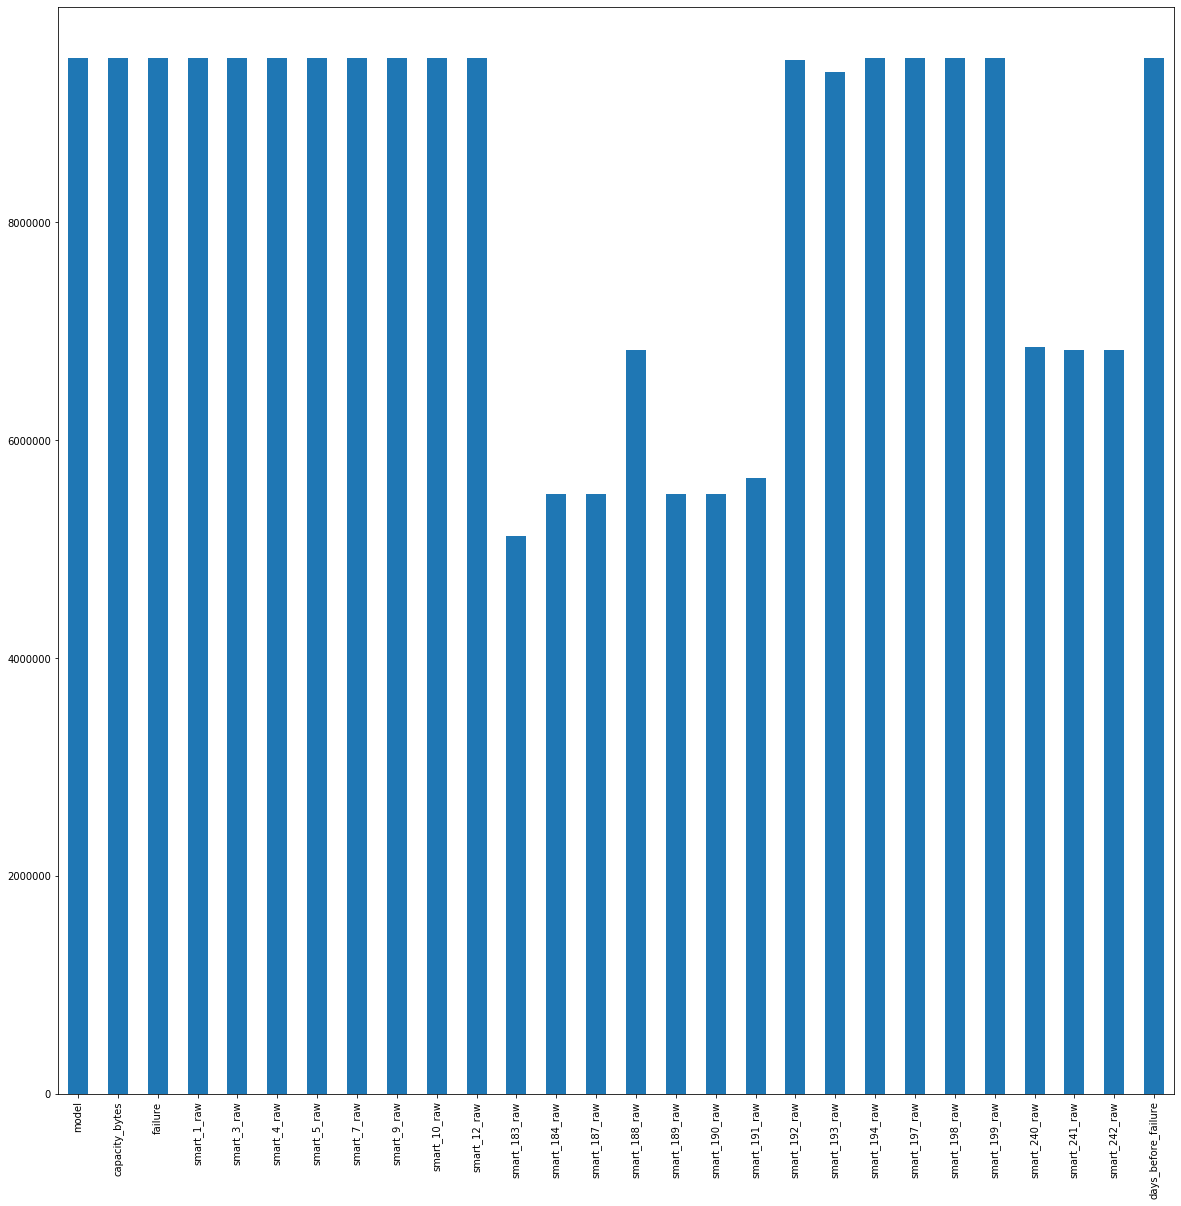

In [5]:
# Plot Column Counts
df_norm.count()[2:].plot(kind='bar', figsize=(20,20))
#plt.savefig('ColumnsCountBefore.png')
plt.show()

# Drop All columns with count less than 5M
df_norm.drop(['smart_2_raw', 'smart_8_raw', 'smart_11_raw', 'smart_13_raw', 
              'smart_22_raw','smart_195_raw','smart_196_raw', 'smart_200_raw',
             'smart_201_raw','smart_220_raw','smart_222_raw', 'smart_223_raw',
              'smart_224_raw','smart_225_raw','smart_226_raw','smart_250_raw',
              'smart_251_raw','smart_252_raw','smart_254_raw'], axis=1, inplace=True)

# Plot New Column Counts
df_norm.count()[2:].plot(kind='bar', figsize=(20,20))
#plt.savefig('ColumnsCountAfter.png')
plt.show()

In [6]:
df_norm.to_csv('./DataP2/preprocessed.csv')

In [1]:
import pandas as pd
df = pd.read_csv('./DataP2/preprocessed.csv')

In [2]:
df_mean = df[df.columns.difference(['date', 'model', 'serial_number', 'days_before_failure'])]
# Replace NaNs with mean
print("start")
df_mean.fillna(df_mean.mean(), inplace=True)

display(df_mean.head())
df_mean.shape

start


C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


,Unnamed: 0,capacity_bytes,failure,smart_10_raw,smart_12_raw,smart_183_raw,smart_184_raw,smart_187_raw,smart_188_raw,smart_189_raw,...,smart_199_raw,smart_1_raw,smart_240_raw,smart_241_raw,smart_242_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw
0,0,1.482490e-311,0,0,14,4.244463,0.004794,0.13668,0.0,13.792622,...,0,0,0.000000e+00,0.000000e+00,0.000000e+00,540,14,0,0.000000e+00,27929
1,1,1.976651e-311,0,0,4,0.000000,0.000000,0.00000,0.0,0.000000,...,0,54551400,1.319155e-321,3.467963e-315,1.316882e-315,0,4,0,1.279800e-317,411
2,2,1.482490e-311,0,0,18,4.244463,0.004794,0.13668,0.0,13.792622,...,0,0,0.000000e+00,0.000000e+00,0.000000e+00,566,19,0,0.000000e+00,27492
3,3,1.482490e-311,0,0,15,4.244463,0.004794,0.13668,0.0,13.792622,...,0,0,0.000000e+00,0.000000e+00,0.000000e+00,507,15,0,0.000000e+00,26640
4,4,1.482490e-311,0,0,10,4.244463,0.004794,0.13668,0.0,13.792622,...,0,0,0.000000e+00,0.000000e+00,0.000000e+00,6250,10,0,0.000000e+00,12198


(9501910, 27)

In [3]:
df_mean[['date', 'model', 'serial_number', 'days_before_failure']] = df.loc[:, ['date', 'model', 'serial_number', 'days_before_failure']]
display(df_mean.head())
df_mean.shape

C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


,Unnamed: 0,capacity_bytes,failure,smart_10_raw,smart_12_raw,smart_183_raw,smart_184_raw,smart_187_raw,smart_188_raw,smart_189_raw,...,smart_242_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,date,model,serial_number,days_before_failure
0,0,1.482490e-311,0,0,14,4.244463,0.004794,0.13668,0.0,13.792622,...,0.000000e+00,540,14,0,0.000000e+00,27929,2016-01-01,Hitachi HDS5C3030ALA630,MJ0351YNG9Z0XA,1000.0
1,1,1.976651e-311,0,0,4,0.000000,0.000000,0.00000,0.0,0.000000,...,1.316882e-315,0,4,0,1.279800e-317,411,2016-01-01,ST4000DM000,Z305B2QN,1000.0
2,2,1.482490e-311,0,0,18,4.244463,0.004794,0.13668,0.0,13.792622,...,0.000000e+00,566,19,0,0.000000e+00,27492,2016-01-01,Hitachi HDS5C3030ALA630,MJ0351YNG9Z7LA,1000.0
3,3,1.482490e-311,0,0,15,4.244463,0.004794,0.13668,0.0,13.792622,...,0.000000e+00,507,15,0,0.000000e+00,26640,2016-01-01,Hitachi HDS5C3030ALA630,MJ0351YNGABYAA,1000.0
4,4,1.482490e-311,0,0,10,4.244463,0.004794,0.13668,0.0,13.792622,...,0.000000e+00,6250,10,0,0.000000e+00,12198,2016-01-01,WDC WD30EFRX,WD-WMC4N2899475,1000.0


(9501910, 31)

In [4]:
df_mean.drop(['Unnamed: 0'], axis=1, inplace=True)
display(df_mean.head())
df_mean.shape

,capacity_bytes,failure,smart_10_raw,smart_12_raw,smart_183_raw,smart_184_raw,smart_187_raw,smart_188_raw,smart_189_raw,smart_190_raw,...,smart_242_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,date,model,serial_number,days_before_failure
0,1.482490e-311,0,0,14,4.244463,0.004794,0.13668,0.0,13.792622,26.053315,...,0.000000e+00,540,14,0,0.000000e+00,27929,2016-01-01,Hitachi HDS5C3030ALA630,MJ0351YNG9Z0XA,1000.0
1,1.976651e-311,0,0,4,0.000000,0.000000,0.00000,0.0,0.000000,30.000000,...,1.316882e-315,0,4,0,1.279800e-317,411,2016-01-01,ST4000DM000,Z305B2QN,1000.0
2,1.482490e-311,0,0,18,4.244463,0.004794,0.13668,0.0,13.792622,26.053315,...,0.000000e+00,566,19,0,0.000000e+00,27492,2016-01-01,Hitachi HDS5C3030ALA630,MJ0351YNG9Z7LA,1000.0
3,1.482490e-311,0,0,15,4.244463,0.004794,0.13668,0.0,13.792622,26.053315,...,0.000000e+00,507,15,0,0.000000e+00,26640,2016-01-01,Hitachi HDS5C3030ALA630,MJ0351YNGABYAA,1000.0
4,1.482490e-311,0,0,10,4.244463,0.004794,0.13668,0.0,13.792622,26.053315,...,0.000000e+00,6250,10,0,0.000000e+00,12198,2016-01-01,WDC WD30EFRX,WD-WMC4N2899475,1000.0


(9501910, 30)

In [5]:
df_mean.to_csv('./DataP2/preprocessed1.csv')





#                                           Machine Learning

In [120]:
df = pd.read_csv('./DataP2/preprocessed1.csv')
df.head()

,Unnamed: 0,capacity_bytes,failure,smart_10_raw,smart_12_raw,smart_183_raw,smart_184_raw,smart_187_raw,smart_188_raw,smart_189_raw,...,smart_242_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,date,model,serial_number,days_before_failure
0,0,1.482490e-311,0,0,14,4.244463,0.004794,0.13668,0.0,13.792622,...,0.000000e+00,540,14,0,0.000000e+00,27929,2016-01-01,Hitachi HDS5C3030ALA630,MJ0351YNG9Z0XA,1000.0
1,1,1.976651e-311,0,0,4,0.000000,0.000000,0.00000,0.0,0.000000,...,1.316882e-315,0,4,0,1.279800e-317,411,2016-01-01,ST4000DM000,Z305B2QN,1000.0
2,2,1.482490e-311,0,0,18,4.244463,0.004794,0.13668,0.0,13.792622,...,0.000000e+00,566,19,0,0.000000e+00,27492,2016-01-01,Hitachi HDS5C3030ALA630,MJ0351YNG9Z7LA,1000.0
3,3,1.482490e-311,0,0,15,4.244463,0.004794,0.13668,0.0,13.792622,...,0.000000e+00,507,15,0,0.000000e+00,26640,2016-01-01,Hitachi HDS5C3030ALA630,MJ0351YNGABYAA,1000.0
4,4,1.482490e-311,0,0,10,4.244463,0.004794,0.13668,0.0,13.792622,...,0.000000e+00,6250,10,0,0.000000e+00,12198,2016-01-01,WDC WD30EFRX,WD-WMC4N2899475,1000.0


In [119]:
df[df['failure'] == 1].count()

days_before_failure    564
failure                564
smart_187_raw          564
smart_188_raw          564
smart_193_raw          564
smart_194_raw          564
smart_197_raw          564
smart_198_raw          564
smart_241_raw          564
smart_242_raw          564
smart_5_raw            564
smart_9_raw            564
dtype: int64

In [3]:
# Constants
RANDOM_SEED = 314
TEST_PCT = 0.2

In [131]:
seagate = df[(df['model'] == 'ST4000DM000') & (df['days_before_failure'] != 1000)]
seagate['days_before_failure'].value_counts()

 0.0      409
 1.0      393
 2.0      377
 3.0      374
 4.0      363
         ... 
 269.0     10
 270.0      7
 271.0      4
 272.0      2
-1.0        1
Name: days_before_failure, Length: 274, dtype: int64

In [98]:
# Feature Selection
seagate = seagate[['date', 'model', 'serial_number', 'failure', 'days_before_failure',
         'smart_5_raw','smart_9_raw','smart_187_raw',
       'smart_188_raw','smart_193_raw','smart_194_raw',
       'smart_197_raw','smart_198_raw','smart_241_raw','smart_242_raw']]

df = df[df.columns.difference(['date', 'model', 'serial_number', 'Unnamed: 0'])]

# Split
train_x, test_x = train_test_split(df, test_size=TEST_PCT, random_state=RANDOM_SEED)

# Transform to DF
trainDf = pd.DataFrame(train_x)
trainDf.columns = df.columns

testDf = pd.DataFrame(test_x)
testDf.columns = df.columns

# Training Data
train_x = trainDf[trainDf.days_before_failure >= 200] # Healthy drives
train_x = train_x.drop(['failure', 'days_before_failure'], axis=1) # drop the Failure, days_before_failure column

# Testing Data
test_y = testDf['days_before_failure']
test_x = testDf.drop(['failure', 'days_before_failure'], axis=1) #drop the failure column

print("Train X")
display(train_x.head())
print("Test X")
display(test_x.head())
print("Test y")
display(test_y.head())

# Scale and Standardize & Transform DF to ndarray
train_x = StandardScaler().fit_transform(train_x)
test_x = StandardScaler().fit_transform(test_x)
test_y = test_y.values

Train X


,smart_187_raw,smart_188_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_241_raw,smart_242_raw,smart_5_raw,smart_9_raw
7388174,0.13668,1.651958e+07,43.0,21.0,0,0,1.339803e+10,4.402090e+10,0,2046
3842360,0.00000,0.000000e+00,9895.0,26.0,0,0,2.115052e+10,2.209344e+11,0,15561
4041055,0.13668,1.651958e+07,243.0,32.0,0,0,1.339803e+10,4.402090e+10,0,15660
3577859,0.13668,1.651958e+07,127.0,17.0,0,0,1.339803e+10,4.402090e+10,0,9993
4019933,0.13668,1.651958e+07,1275.0,30.0,0,0,1.339803e+10,4.402090e+10,0,47683


Test X


,smart_187_raw,smart_188_raw,smart_193_raw,smart_194_raw,smart_197_raw,smart_198_raw,smart_241_raw,smart_242_raw,smart_5_raw,smart_9_raw
4231620,0.00000,0.000000e+00,3161.0,34.0,0,0,2.346965e+10,3.598614e+09,0,4185
551695,0.00000,0.000000e+00,26095.0,28.0,0,0,1.068704e-313,2.674706e-314,0,4790
3537603,0.00000,0.000000e+00,46797.0,17.0,0,0,2.214582e+10,1.893561e+11,0,19635
5650604,0.00000,0.000000e+00,14845.0,25.0,0,0,2.369022e+10,1.802856e+11,0,11645
4382848,0.13668,1.651958e+07,42.0,32.0,0,0,1.339803e+10,4.402090e+10,0,27959


Test y


4231620    1000.0
551695     1000.0
3537603    1000.0
5650604    1000.0
4382848    1000.0
Name: days_before_failure, dtype: float64

In [19]:
train_x.shape[1]
train_x.shape
test_x.shape

(1900382, 25)

In [101]:
# AutoEncoder

# Parameters
nb_epoch = 100
batch_size = 50000
# Network 25 -> 20 -> 12 -> 5    -> 12 -> 20 -> 25
input_dim = train_x.shape[1] #num of columns 25
encoding_dim = 13
hidden_dim1 = 5
hidden_dim2 = 4
learning_rate = 1e-7 # 1e-7

# Encoder
input_layer = keras.Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim1, activation="relu")(encoder)
#encoder = Dense(hidden_dim2, activation="relu")(encoder) #

# Decoder
decoder = Dense(hidden_dim1, activation='relu')(encoder)
#decoder = Dense(hidden_dim1, activation='relu')(decoder) #
decoder = Dense(input_dim, activation='relu')(decoder) 

# Model
autoencoder = keras.Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
autoencoder.summary()

# Train Model


#cp = keras.callbacks.ModelCheckpoint(filepath="autoencoder.h5",
#                               save_best_only=True,
#                               verbose=0)
#logdir = os.path.join('logs')
#tb = keras.callbacks.TensorBoard(log_dir=logdir,
#                histogram_freq=0,
#                write_graph=True,
#                write_images=True)

history = autoencoder.fit(train_x, train_x,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(test_x, test_x),
                    verbose=1, #callbacks=[cp, tb]
                    ).history

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_28 (Dense)             (None, 13)                143       
_________________________________________________________________
dense_29 (Dense)             (None, 5)                 70        
_________________________________________________________________
dense_30 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_31 (Dense)             (None, 10)                60        
Total params: 303
Trainable params: 303
Non-trainable params: 0
_________________________________________________________________


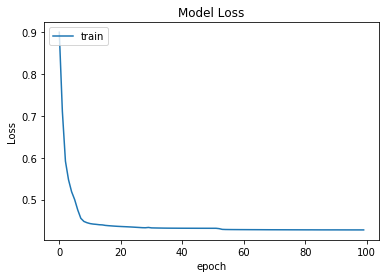

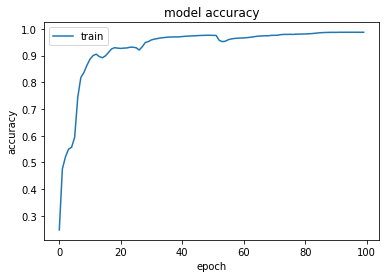

In [104]:
# Model Loss
plt.plot(history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.savefig('ModelLossAE5.png')
plt.show()

# Model Loss
plt.plot(history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('ModelAccuracyAE5.png')
plt.show()

In [105]:
# Save Model

# serialize model to JSON
model_json = autoencoder.to_json()
with open("autoencoderModel5_90.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
autoencoder.save_weights("autoencoder5_90.h5")
print("Saved model to disk")

Saved model to disk


In [107]:
# Load Model

# load json and create model
json_file = open('./Models/AE5_90/autoencoderModel5_90.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./Models/AE5_90/autoencoder5_90.h5")
print("Loaded model from disk")

Loaded model from disk


In [108]:
# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

pred = loaded_model.predict(test_x, verbose = 1)
mse = np.mean(np.power(test_x - pred, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': test_y})
error_df.head()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,Reconstruction_error,True_class
0,0.094145,1000.0
1,0.222080,1000.0
2,0.348823,1000.0
3,0.032433,1000.0
4,0.001482,1000.0


Healthy MSE = 0.48831235876617773
Unhealthy MSE = 5.922422661866096


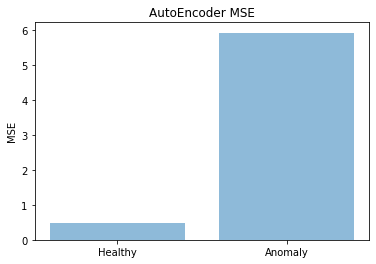

In [52]:
# Metrics
healthy_test = test_x[np.where(test_y >100)]
anomaly_test = test_x[np.where(test_y < 100)]

pred_healthy = loaded_model.predict(healthy_test)
pred_anomaly = loaded_model.predict(anomaly_test)

mse_healthy = np.sqrt(metrics.mean_squared_error(pred_healthy, healthy_test))
mse_anomaly = np.sqrt(metrics.mean_squared_error(pred_anomaly, anomaly_test))

print(f'Healthy MSE = {mse_healthy}')
print(f'Unhealthy MSE = {mse_anomaly}')

# Plot Healthy MSE vs Anomaly MSE
y_pos = np.arange(len([mse_healthy, mse_anomaly]))
plt.bar(y_pos, [mse_healthy, mse_anomaly], align='center', alpha=0.5)
plt.xticks(y_pos, ['Healthy', 'Anomaly'])
plt.ylabel('MSE')
plt.title('AutoEncoder MSE')
plt.savefig('MSE_AE2.png')
plt.show()


In [109]:
failures_score = error_df.iloc[np.where(test_y < 100)]
healthy_score = error_df.iloc[np.where(test_y > 100)]

#failures_score_norm['Reconstruction_error'] = StandardScaler().fit_transform(failures_score[['Reconstruction_error']])
#healthy_score_norm['Reconstruction_error'] = StandardScaler().fit_transform(healthy_score[['Reconstruction_error']])


display(failures_score.describe())
display(healthy_score.describe())

,Reconstruction_error,True_class
count,4453.000000,4453.000000
mean,118.956513,37.348978
std,4000.723071,29.876715
min,0.000327,0.000000
25%,0.032257,12.000000
50%,0.122391,29.000000
75%,0.190542,60.000000
max,211395.239142,99.000000


,Reconstruction_error,True_class
count,1.895892e+06,1.895892e+06
mean,1.494906e-01,9.988139e+02
std,1.471734e+01,3.138427e+01
min,1.109006e-05,1.010000e+02
25%,2.684633e-02,1.000000e+03
50%,1.381501e-01,1.000000e+03
75%,1.847419e-01,1.000000e+03
max,1.165519e+04,1.000000e+03


In [117]:
print(failures_score.shape)
failures_score[(failures_score['Reconstruction_error'] > 0) & (failures_score['Reconstruction_error'] <1)].count()

print(healthy_score.shape)
healthy_score[(healthy_score['Reconstruction_error'] > 0) & (healthy_score['Reconstruction_error'] <1)].count()

(4453, 2)
(1895892, 2)


Reconstruction_error    1895825
True_class              1895825
dtype: int64

Reconstruction_error    1900281
True_class              1900281
dtype: int64


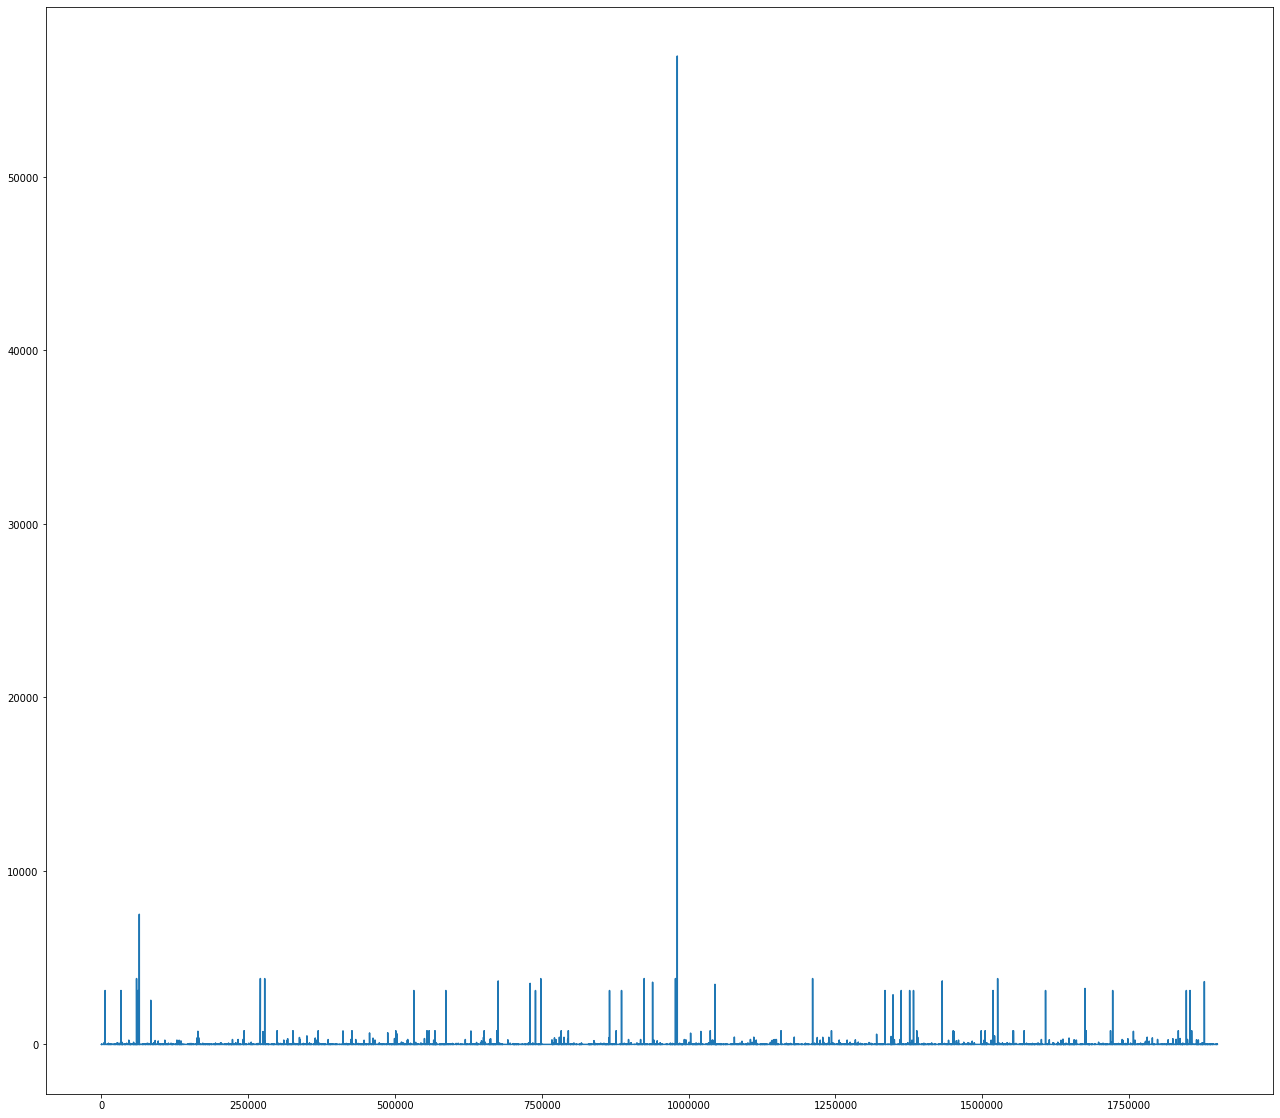

In [40]:
# Get Number of healty from reconstruction error range
from matplotlib.pyplot import figure
print(healthy_score.count())
left = 2.751995e-01 - (2*4.429506e+01 / 1900281.0)
right = 2.751995e-01 + (2*4.429506e+01 / 1900281.0)
healthy_score[(healthy_score['Reconstruction_error'] >= left)
                   & (healthy_score['Reconstruction_error'] <= right)].count()

figure(figsize=(22,20))
plt.plot(healthy_score['Reconstruction_error'].index , healthy_score['Reconstruction_error'])

In [33]:
print(failures_score.count())
failures_score[(failures_score['Reconstruction_error'] >= 0)
                   & (failures_score['Reconstruction_error'] <= 0.54589)].count()

Reconstruction_error    114
True_class              114
dtype: int64


Reconstruction_error    65
True_class              65
dtype: int64

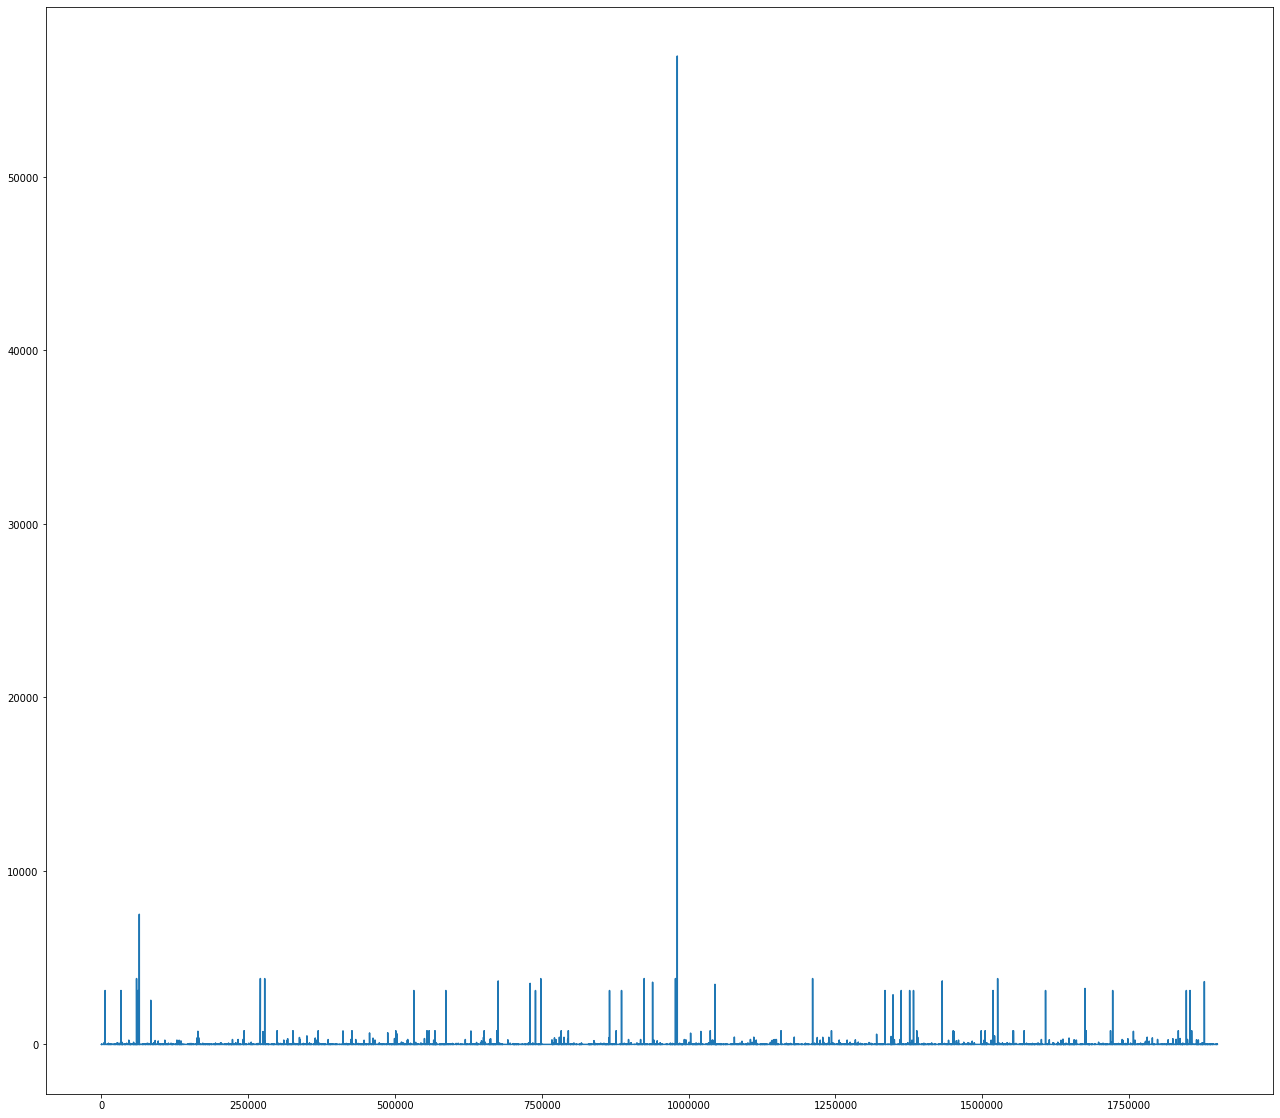

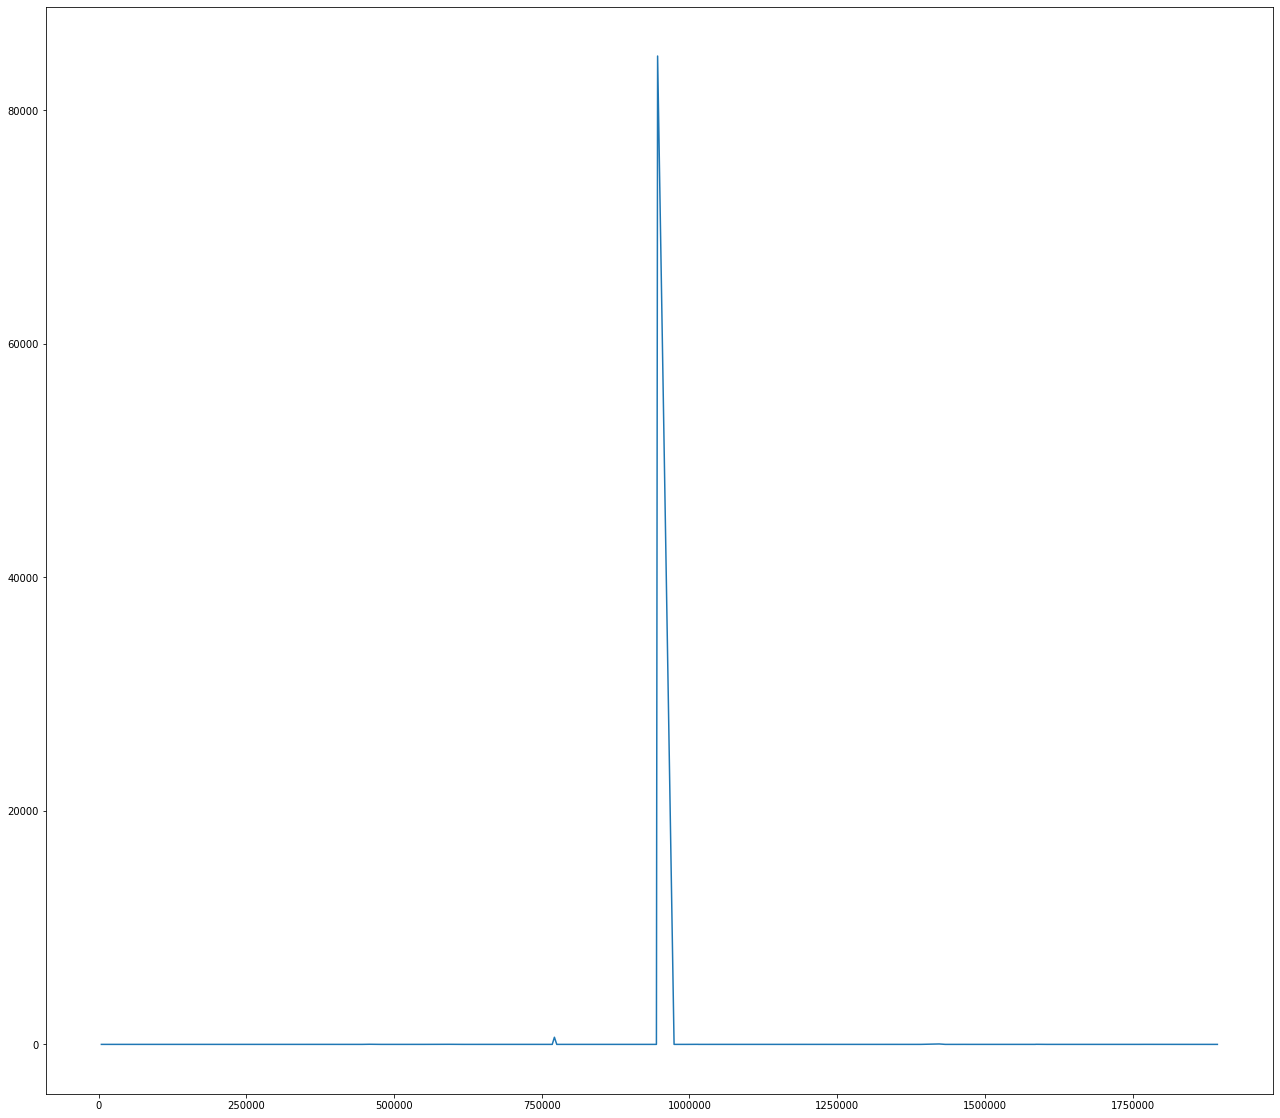

In [47]:
figure(figsize=(22,20))
plt.plot( healthy_score['Reconstruction_error'])
plt.show()

figure(figsize=(22,20))
plt.plot(failures_score['Reconstruction_error'])
plt.show()

In [49]:
testDf[testDf.days_before_failure <= 100]

,capacity_bytes,days_before_failure,failure,smart_10_raw,smart_12_raw,smart_183_raw,smart_184_raw,smart_187_raw,smart_188_raw,smart_189_raw,...,smart_199_raw,smart_1_raw,smart_240_raw,smart_241_raw,smart_242_raw,smart_3_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw
6992079,1.976651e-311,13.0,0,0,6,0.000000,0.000000,0.00000,0.000000e+00,0.000000,...,0,23642136,2.075100e+04,2.530761e+10,1.609102e+11,0,6,0,3.169597e+08,20796
5016337,1.976651e-311,28.0,0,0,4,0.000000,0.000000,0.00000,0.000000e+00,4.000000,...,0,75919632,1.565800e+04,2.029972e+10,1.623779e+11,0,4,0,8.296906e+08,15676
7948261,1.976651e-311,9.0,0,0,2,0.000000,0.000000,0.00000,0.000000e+00,0.000000,...,0,179070480,6.180000e+03,2.491307e+10,1.282366e+10,0,3,0,2.989542e+08,6564
1791037,1.581370e-312,18.0,0,0,10,4.244463,0.000000,0.00000,6.422853e-323,0.000000,...,0,226528296,7.632607e-310,1.888791e-314,1.637593e-314,0,10,0,3.071809e-315,28915
8323333,1.976651e-311,10.0,0,0,17,0.000000,0.000000,0.00000,0.000000e+00,4.000000,...,0,174604544,2.752100e+04,3.114929e+10,1.700938e+11,0,17,0,8.797232e+08,27745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639340,1.976651e-311,7.0,0,0,1,0.000000,0.000000,0.00000,0.000000e+00,0.000000,...,0,51367256,2.885343e-320,7.234660e-314,1.129505e-313,0,12,0,1.622055e-315,5842
2037777,1.976651e-311,89.0,0,0,31,0.000000,0.000000,0.00000,0.000000e+00,1.000000,...,0,81607880,6.032047e-320,1.107926e-313,7.484792e-313,0,31,0,3.227044e-315,12241
3101635,1.976651e-311,43.0,0,0,12,1.000000,0.000000,0.00000,0.000000e+00,9.000000,...,0,159331616,2.099500e+04,2.422371e+10,2.085329e+11,0,12,0,5.088797e+08,21053
1419682,7.907120e-313,2.0,0,0,15,4.244463,0.004794,0.13668,0.000000e+00,13.792622,...,0,0,0.000000e+00,0.000000e+00,0.000000e+00,4133,16,0,0.000000e+00,38267
